In [1]:
import math
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import gwpy

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import normalize

%matplotlib inline

Using TensorFlow backend.


**To-do:

Remove the none_of_the_above category 

In [2]:
from numpy.random import random
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

In [ ]:
import h5py

datah5 = pd.read_hdf('trainingsetv1d1.h5', 'key')

In [15]:
# timeSeries = TimeSeries(data["event_time"])
# timeSeries
# gwdata = TimeSeries.get('H1:LDAS-STRAIN', 'September 16 2010 06:40', 'September 16 2010 06:50')
# spec = FrequencySeries([1,2,3,4,5,6,7,8,9,10], f0=0, df=1)
# spec
# spectrum = gwdata.asd(8, 4)

In [16]:
data = pd.read_csv('trainingset_v1d1_metadata.csv') 
features = [ # Selects the features that will go into the model
    "duration",
    "peak_frequency",
    "central_freq",
    "bandwidth",
    "amplitude",
    "snr",
    "label"]

In [17]:
filtered = data[features] # gets only the selected features for the datapoints
labels = data["label"] # gets glitch classification for validation purposes 
numGlitches = len(labels.unique())

In [18]:
labelConvertionDict = createLabelConvertionDict(filtered) # dict to convert strLabels to int representations for the model
numLabels = convertStringLabelsToNumeric(labels, labelConvertionDict) # data[label] is now converted to numerical values
labelConvertionDict

{'Wandering_Line': 0,
 'None_of_the_Above': 1,
 'No_Glitch': 2,
 'Koi_Fish': 3,
 'Light_Modulation': 4,
 'Scratchy': 5,
 'Repeating_Blips': 6,
 'Low_Frequency_Lines': 7,
 'Scattered_Light': 8,
 'Paired_Doves': 9,
 'Violin_Mode': 10,
 '1400Ripples': 11,
 'Blip': 12,
 'Whistle': 13,
 'Tomte': 14,
 'Power_Line': 15,
 '1080Lines': 16,
 'Extremely_Loud': 17,
 'Low_Frequency_Burst': 18,
 'Air_Compressor': 19,
 'Chirp': 20,
 'Helix': 21}

In [19]:
filtered = filtered.drop(["label"], axis=1) # remove labels from dataframe

In [20]:
dataSize = len(data) # number of datapoints in the file
trainSize = math.ceil(0.8 * dataSize) # first 80% elements of dataset become training. Remaining 20% is used for validation
inputSize = len(filtered.columns) # number of features going into the model

In [21]:
trainingSet = filtered[:trainSize] 
trainingLabels = numLabels[:trainSize]
validationSet = filtered[trainSize:]  
validationLabels = numLabels[trainSize:]

In [24]:
model = keras.Sequential() # creates classifier
model.add(keras.layers.Dense(64, input_dim=inputSize, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.summary()
example_batch = trainingSet[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


array([[ -71.1635 ],
       [-105.29083],
       [-170.81453],
       [-213.79341],
       [-221.46153],
       [-242.62451],
       [-137.71727],
       [ -92.71867],
       [-195.51175],
       [-262.857  ]], dtype=float32)

In [108]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print('.', end='')


history = model.fit(
  trainingSet, trainingLabels,
  epochs=1024, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [116]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.describe()

1024

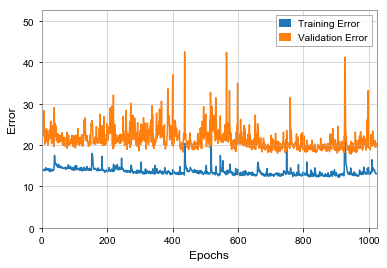

In [120]:
plt.figure()
plt.plot(hist["epoch"], hist["loss"], label = "Training Error")
plt.plot(hist["epoch"], hist["val_loss"], label = "Validation Error")
plt.xlim([0, len(hist)])
plt.ylim([0, 10 + max(max(hist["loss"]), max(hist["val_loss"]))])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [85]:
# The patience parameter is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

# history = model.fit(trainingSet, trainingLabels, epochs=100,
#                     batch_size=32)


In [121]:
preds = model.predict(validationSet) # uses features from 20% of the original set to try to predict the glitch type
preds = [round(p[0], 0) for p in preds]
# score = score(preds, validationLabels, labelConvertionDict) # compares the predicted glitch to the actual glitch to check accuracy 
roundScore(preds, validationLabels)

8.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
15.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
7.0 <- pred | actual -> 3
15.0 <- pred | actual -> 17
17.0 <- pred | actual -> 16
10.0 <- pred | actual -> 12
13.0 <- pred | actual -> 12
4.0 <- pred | actual -> 3
8.0 <- pred | actual -> 12
16.0 <- pred | actual -> 16
11.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
11.0 <- pred | actual -> 8
9.0 <- pred | actual -> 20
11.0 <- pred | actual -> 12
7.0 <- pred | actual -> 3
12.0 <- pred | actual -> 12
15.0 <- pred | actual -> 16
16.0 <- pred | actual -> 16
11.0 <- pred | actual -> 12
3.0 <- pred | actual -> 3
7.0 <- pred | actual -> 17
11.0 <- pred | actual -> 12
17.0 <- pred | actual -> 19
11.0 <- pred | actual -> 12
15.0 <- pred | actual -> 17
9.0 <- pred | actual -> 16
15.0 <- pred | actual -> 16
11.0 <- pred | actual -> 16
8.0 <- pred | actual -> 12
14.0 <- pred | actual -> 16
15.0 <- pred | actual -> 16
3.0 <- pr

11.0 <- pred | actual -> 8
10.0 <- pred | actual -> 8
-0.0 <- pred | actual -> 8
9.0 <- pred | actual -> 8
15.0 <- pred | actual -> 15
10.0 <- pred | actual -> 8
10.0 <- pred | actual -> 8
18.0 <- pred | actual -> 8
11.0 <- pred | actual -> 7
10.0 <- pred | actual -> 18
11.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
14.0 <- pred | actual -> 7
6.0 <- pred | actual -> 18
12.0 <- pred | actual -> 18
10.0 <- pred | actual -> 18
11.0 <- pred | actual -> 17
15.0 <- pred | actual -> 15
15.0 <- pred | actual -> 15
14.0 <- pred | actual -> 15
11.0 <- pred | actual -> 2
8.0 <- pred | actual -> 18
12.0 <- pred | actual -> 15
14.0 <- pred | actual -> 15
16.0 <- pred | actual -> 15
12.0 <- pred | actual -> 15
15.0 <- pred | actual -> 15
9.0 <- pred | actual -> 8
11.0 <- p

5.0 <- pred | actual -> 4
5.0 <- pred | actual -> 4
8.0 <- pred | actual -> 4
5.0 <- pred | actual -> 4
8.0 <- pred | actual -> 4
5.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
8.0 <- pred | actual -> 4
5.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
9.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
6.0 <- pred | actual -> 4
3.0 <- pred | actual -> 3
11.0 <- pred | actual -> 4
7.0 <- pred | actual -> 4
4.0 <- pred | actual -> 3
11.0 <- pred | actual -> 4
9.0 <- pred | actual -> 4
9.0 <- pred | actual -> 4
3.0 <- pred | actual -> 3
3.0 <- pred | actual -> 3
4.0 <- pred | actual -> 4
3.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
11.0 <- pred | actual -> 4
6.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
6.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
6.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
4.0 <- pred | actual -> 4
5.0 <- pred | actual -> 4
4.0 

10.0 <- pred | actual -> 17
9.0 <- pred | actual -> 11
8.0 <- pred | actual -> 8
9.0 <- pred | actual -> 5
8.0 <- pred | actual -> 15
12.0 <- pred | actual -> 7
11.0 <- pred | actual -> 12
9.0 <- pred | actual -> 5
10.0 <- pred | actual -> 2
4.0 <- pred | actual -> 3
9.0 <- pred | actual -> 12
16.0 <- pred | actual -> 16
9.0 <- pred | actual -> 10
14.0 <- pred | actual -> 15
14.0 <- pred | actual -> 15
11.0 <- pred | actual -> 18
3.0 <- pred | actual -> 2
11.0 <- pred | actual -> 7
11.0 <- pred | actual -> 7
9.0 <- pred | actual -> 11
6.0 <- pred | actual -> 5
11.0 <- pred | actual -> 13
6.0 <- pred | actual -> 1
13.0 <- pred | actual -> 17
5.0 <- pred | actual -> 5
4.0 <- pred | actual -> 5
10.0 <- pred | actual -> 13
7.0 <- pred | actual -> 5
9.0 <- pred | actual -> 12
8.0 <- pred | actual -> 5
14.0 <- pred | actual -> 15
14.0 <- pred | actual -> 15
10.0 <- pred | actual -> 13
9.0 <- pred | actual -> 18
16.0 <- pred | actual -> 21
11.0 <- pred | actual -> 12
13.0 <- pred | actual -> 

9.0 <- pred | actual -> 15
10.0 <- pred | actual -> 7
15.0 <- pred | actual -> 18
9.0 <- pred | actual -> 12
12.0 <- pred | actual -> 10
10.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
17.0 <- pred | actual -> 17
11.0 <- pred | actual -> 17
16.0 <- pred | actual -> 17
15.0 <- pred | actual -> 17
11.0 <- pred | actual -> 12
4.0 <- pred | actual -> 17
15.0 <- pred | actual -> 17
10.0 <- pred | actual -> 17
9.0 <- pred | actual -> 12
16.0 <- pred | actual -> 17
8.0 <- pred | actual -> 17
12.0 <- pred | actual -> 12
21.0 <- pred | actual -> 21
11.0 <- pred | actual -> 17
12.0 <- pred | actual -> 21
16.0 <- pred | actual -> 21
11.0 <- pred | actual -> 18
22.0 <- pred | actual -> 21
10.0 <- pred | actual -> 17
11.0 <- pred | actual -> 17
17.0 <- pred | actual -> 19
6.0 <- pred | actual -> 15
12.0 <- pred | actual -> 21
21.0 <- pred | actual -> 21
11.0 <- pred | actual -> 12
9.0 <- pred | actual -> 8
16.0 <- pred | actual -> 17
14.

9.0 <- pred | actual -> 12
4.0 <- pred | actual -> 3
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
9.0 <- pred | actual -> 11
12.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
8.0 <- pred | actual -> 12
10.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
9.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
7.0 <- pred | actual -> 5
12.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
8.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
12.0 <- pred | actual -> 12
11.0 <- pred | actual -> 12
9.0 <- pred

15.756434400502197

In [ ]:
# plot for preds vs actual

In [123]:
def roundScore(preds, vals):
    correct = 0
    total = 0
    for i in range(len(preds)):
        print(str(preds[i]) + ' <- pred | actual -> ' + str(vals[i]))
        if (preds[i] == vals[i]):
            correct += 1
        total += 1
    return 'Accuracy: ' + str(100.0 * correct / total) + '%'

In [106]:
def numScore(predictions, validation):
    #keras.metrics.accuracy(y_true, y_pred)
    error = 0
    total = 0
    for i in range(len(predictions)):
        error += abs(predictions[i] - validation[i])
        total += validation[i]
    return str(round(100.0 * (1 - (error/total))[0], 2)) + '%'

In [8]:
def score(predictions, validation, labelConvertionDict):
    correct = 0
    count = 0
    # predictions and validation are floats and must be converted to the glitch string label
    predictions = convertNumericLabelsToString(predictions.round(0), labelConvertionDict)
    validation = convertNumericLabelsToString(validation, labelConvertionDict)
    for i in range(len(predictions)):
        print(str(predictions[i]) + ' <- pred. | actual -> ' + str(validation[i]))
        if predictions[i] == validation[i]:
            correct += 1
        count += 1
    print("Correct: " + str(correct))
    print("Total: " + str(count))
    print("Accuracy: " + str(round((100.0 * correct) / count, 2)) + "%")
    return (100.0 * correct) / count

In [9]:
def createLabelConvertionDict(data): # Creates a dict to convert between the string labels to numeric values
    dataAvg = data.groupby("label").mean()
    numGlitches = len(data["label"].unique())
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_nD = min_max_scaler.fit_transform(dataAvg)
    distances = dict()
    labels_sorted = np.sort(data["label"].unique()) # alphabetical order to match with normalized
    for i in range(len(labels_sorted)):
        distances[labels_sorted[i]] = getDistance(normalized_nD[i], 0.5)
    maxValue = max(distances.values())
    for key in distances.keys():
        distances[key] = 1 - ((maxValue - distances[key]) / (maxValue))
    sortedDist = sorted(distances.items(), key=lambda x: x[1])
    count = 0
    convertionDict = dict()
    for tup in sortedDist:
        convertionDict[tup[0]] = count
        count += 1
    return convertionDict

In [10]:
def convertStringLabelsToNumeric(strLabels, labelConvertionDict): # Converts the labels set to their num values from the dict
    numLabels = [elem for elem in strLabels] # deep copy
    for i in range(len(numLabels)):
        numLabels[i] = labelConvertionDict[numLabels[i]] # replace string label value for corresponding the numValue from dict
    return numLabels

In [11]:
def convertNumericLabelsToString(intLabels, labelConvertionDict):
    converted = [i for i in intLabels] # deep copy
    converted = [i % len(labelConvertionDict) for i in converted] # Prevents prediction to be outside range of num values. Basically takes a random guess if it happens
    strValues = list(labelConvertionDict.keys())
    intToStrDict = dict()
    key = 0
    for val in strValues: # values will be in the same order as the labelConvertionDict so this is a safe operation
        intToStrDict[key] = val
        key += 1
    for i in range(len(converted)):
        converted[i] = str(intToStrDict[int(converted[i])]) # puts in the converted list the stringVal corresponding to the intLabel
    return converted
        

In [14]:
def getDistance(datapoint, center):
    toSqrt = 0
    for i in range(len(datapoint)):
        toSqrt += (datapoint[i] - center)**2
    return math.sqrt(toSqrt)